In [2]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [3]:
ls

MyDrive/  Shareddrives/


In [4]:
cd/gdrive/MyDrive/eyes/

/gdrive/MyDrive/eyes


In [5]:
ls

closedLeftEyes/  closedRightEyes/  openLeftEyes/  openRightEyes/


In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [7]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=20
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/eyes",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4856 files belonging to 4 classes.


In [9]:
class_names = dataset.class_names
class_names

['closedLeftEyes', 'closedRightEyes', 'openLeftEyes', 'openRightEyes']

In [10]:
len(dataset)

79

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[177. 177. 177.]
  [177. 177. 177.]
  [177. 177. 177.]
  ...
  [163. 163. 163.]
  [163. 163. 163.]
  [163. 163. 163.]]

 [[177. 177. 177.]
  [177. 177. 177.]
  [177. 177. 177.]
  ...
  [163. 163. 163.]
  [163. 163. 163.]
  [163. 163. 163.]]

 [[177. 177. 177.]
  [177. 177. 177.]
  [177. 177. 177.]
  ...
  [163. 163. 163.]
  [163. 163. 163.]
  [163. 163. 163.]]

 ...

 [[157. 157. 157.]
  [157. 157. 157.]
  [157. 157. 157.]
  ...
  [171. 171. 171.]
  [171. 171. 171.]
  [171. 171. 171.]]

 [[157. 157. 157.]
  [157. 157. 157.]
  [157. 157. 157.]
  ...
  [171. 171. 171.]
  [171. 171. 171.]
  [171. 171. 171.]]

 [[157. 157. 157.]
  [157. 157. 157.]
  [157. 157. 157.]
  ...
  [171. 171. 171.]
  [171. 171. 171.]
  [171. 171. 171.]]], shape=(256, 256, 3), dtype=float32)
[3 3 3 2 2 0 0 1 2 3 2 2 0 2 2 3 3 3 0 3 3 1 0 1 0 0 3 1 3 1 3 0 2 2 3 1 3
 3 3 2 3 3 2 2 2 0 0 3 2 0 2 3 3 0 3 2 0 1 1 1 3 2]


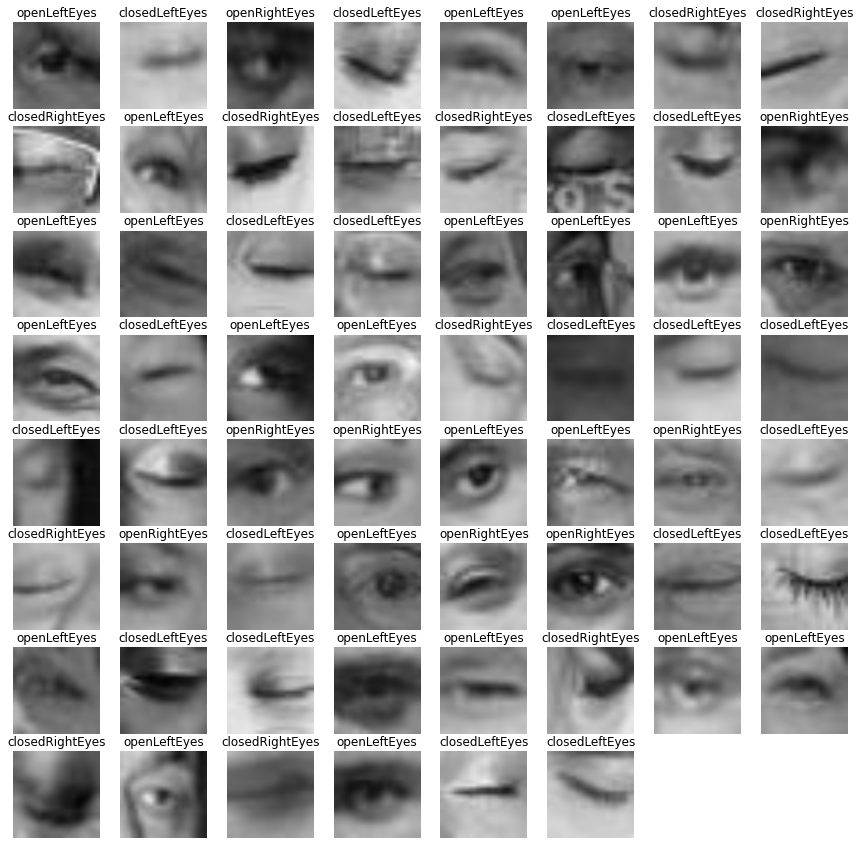

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
63/63 [==============================] - 919s 5s/step - loss: 1.4169 - accuracy: 0.3103
Epoch 2/20
63/63 [==============================] - 285s 5s/step - loss: 1.0222 - accuracy: 0.5829
Epoch 3/20
63/63 [==============================] - 286s 5s/step - loss: 0.6842 - accuracy: 0.7514
Epoch 4/20
63/63 [==============================] - 287s 5s/step - loss: 0.5796 - accuracy: 0.7860
Epoch 5/20
63/63 [==============================] - 284s 5s/step - loss: 0.5103 - accuracy: 0.8111
Epoch 6/20
63/63 [==============================] - 285s 5s/step - loss: 0.4710 - accuracy: 0.8303
Epoch 7/20
63/63 [==============================] - 286s 5s/step - loss: 0.4237 - accuracy: 0.8474
Epoch 8/20
63/63 [==============================] - 286s 5s/step - loss: 0.3932 - accuracy: 0.8584
Epoch 9/20
63/63 [==============================] - 289s 5s/step - loss: 0.3714 - accuracy: 0.8582
Epoch 10/20
63/63 [==============================] - 286s 5s/step - loss: 0.3307 - accuracy: 0.8889
Epoch 11/

In [26]:
model.evaluate(test_ds)

9/9 [==============================] - 22s 1s/step - loss: 0.1600 - accuracy: 0.9399


[0.15997403860092163, 0.9399224519729614]

In [27]:
acc = history.history['accuracy']
loss = history.history['loss']

No handles with labels found to put in legend.


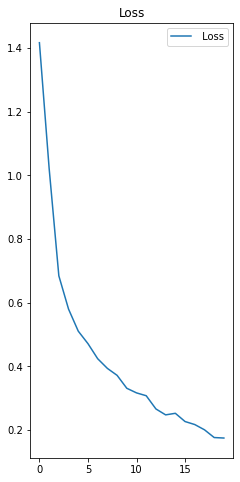

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [29]:
image_path = "/gdrive/My Drive/Zorica_Radovic_0001_L.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [30]:
pred = model.predict(scaled_img)

In [31]:
output = class_names[np.argmax(pred)]

In [32]:
output

'openRightEyes'

In [33]:
model.save("eyes.h5")